### 1. Aggregate the Data by Zone and Time

In [1]:
import pandas as pd
import numpy as np

# Load the trips data
# Loading filtered_df_2
# Path to the Parquet file
file_path = 'filtered_df_2.parquet'
# Load the Parquet file into a DataFrame
df_trips = pd.read_parquet(file_path)

# Extract relevant time features
df_trips['pickup_date'] = df_trips['tpep_pickup_datetime'].dt.date

# Aggregate total pickups per zone per day
zone_daily_demand = df_trips.groupby(['PULocationID', 'pickup_date']).size().reset_index(name='pickup_count')

# Pivot to create a time series for each zone
zone_time_series = zone_daily_demand.pivot(index='pickup_date', columns='PULocationID', values='pickup_count').fillna(0)

# Transpose for clustering (zones as rows, time series as columns)
zone_time_series_matrix = zone_time_series.T


In [2]:
zone_time_series_matrix.head()

pickup_date,2023-11-01,2023-11-02,2023-11-03,2023-11-04,2023-11-05,2023-11-06,2023-11-07,2023-11-08,2023-11-09,2023-11-10,...,2024-09-20,2024-09-21,2024-09-22,2024-09-23,2024-09-24,2024-09-25,2024-09-26,2024-09-27,2024-09-28,2024-09-29
PULocationID,,,,,,,,,,,,,,,,,,,,,
1,1.0,2.0,3.0,1.0,4.0,0.0,1.0,0.0,0.0,0.0,...,1.0,1.0,3.0,0.0,0.0,4.0,1.0,2.0,0.0,1.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,76.0,66.0,98.0,279.0,197.0,37.0,50.0,61.0,63.0,111.0,...,106.0,290.0,273.0,41.0,52.0,58.0,72.0,125.0,364.0,253.0
6,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Dynamic Time Warping for clustering

In [3]:
import numpy as np
import pandas as pd
from tslearn.clustering import TimeSeriesKMeans
from tslearn.metrics import dtw, cdist_dtw
from tslearn.preprocessing import TimeSeriesScalerMeanVariance
from sklearn.cluster import AgglomerativeClustering

# Suppose zone_time_series_matrix has shape (num_zones, num_timepoints).
# Each row is one zone’s time series over time.

# 1. (Optional) Scale each time series
scaler = TimeSeriesScalerMeanVariance()
zone_ts_scaled = scaler.fit_transform(zone_time_series_matrix)

# 2. Compute DTW distance matrix (num_zones x num_zones)
distance_matrix = cdist_dtw(zone_ts_scaled)

# 3. Cluster using hierarchical clustering (or any method needing a precomputed dist matrix)
agglo = AgglomerativeClustering(
    n_clusters=5,               # choose your k
    affinity='precomputed',
    linkage='average'           # or 'complete', etc.
)
labels = agglo.fit_predict(distance_matrix)

zone_ids = zone_time_series.columns  # These are the actual PULocationIDs
df_clusters = pd.DataFrame({
    'zone_id': zone_ids,  # Dynamic mapping based on actual PULocationIDs
    'cluster': labels
})

/dcs/pg24/u2164966/.local/lib/python3.11/site-packages/sklearn/cluster/_agglomerative.py:1006: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(


/dcs/pg24/u2164966/.local/lib/python3.11/site-packages/sklearn/cluster/_agglomerative.py:1006: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
/dcs/pg24/u2164966/.local/lib/python3.11/site-packages/sklearn/cluster/_agglomerative.py:1006: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
/dcs/pg24/u2164966/.local/lib/python3.11/site-packages/sklearn/cluster/_agglomerative.py:1006: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
/dcs/pg24/u2164966/.local/lib/python3.11/site-packages/sklearn/cluster/_agglomerative.py:1006: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
/dcs/pg24/u2164966/.local/lib/python3.11/site-packages/sklearn/cluster/_agglomerative.py:100

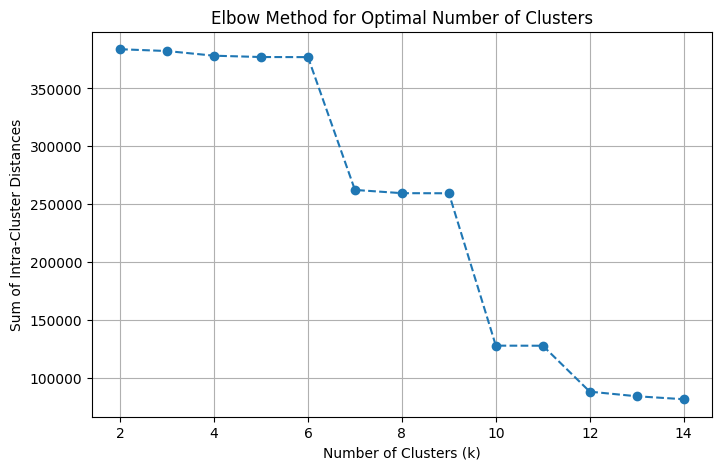

In [4]:
import matplotlib.pyplot as plt

# Range of cluster numbers to try
k_values = range(2, 15)  # Try between 2 and 15 clusters
intra_cluster_distances = []

# Iterate over different numbers of clusters
for k in k_values:
    agglo = AgglomerativeClustering(
        n_clusters=k,
        affinity='precomputed',
        linkage='average'  # Or 'complete', etc.
    )
    labels = agglo.fit_predict(distance_matrix)
    
    # Calculate sum of distances within clusters
    sum_distances = 0
    for cluster_id in set(labels):
        # Find indices of zones in the current cluster
        cluster_indices = np.where(labels == cluster_id)[0]
        
        # Compute pairwise distances within the cluster
        cluster_distances = distance_matrix[np.ix_(cluster_indices, cluster_indices)]
        sum_distances += cluster_distances.sum() / 2  # Avoid double counting
    intra_cluster_distances.append(sum_distances)

# Plot Elbow Curve
plt.figure(figsize=(8, 5))
plt.plot(k_values, intra_cluster_distances, marker='o', linestyle='--')
plt.title("Elbow Method for Optimal Number of Clusters")
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Sum of Intra-Cluster Distances")
plt.grid()
plt.show()


In [8]:
import numpy as np
import pandas as pd
from tslearn.clustering import TimeSeriesKMeans
from tslearn.metrics import dtw, cdist_dtw
from tslearn.preprocessing import TimeSeriesScalerMeanVariance
from sklearn.cluster import AgglomerativeClustering

# Suppose zone_time_series_matrix has shape (num_zones, num_timepoints).
# Each row is one zone’s time series over time.

# 1. (Optional) Scale each time series
scaler = TimeSeriesScalerMeanVariance()
zone_ts_scaled = scaler.fit_transform(zone_time_series_matrix)

# 2. Compute DTW distance matrix (num_zones x num_zones)
distance_matrix = cdist_dtw(zone_ts_scaled)

# 3. Cluster using hierarchical clustering (or any method needing a precomputed dist matrix)
agglo = AgglomerativeClustering(
    n_clusters=9,               # choose your k
    affinity='precomputed',
    linkage='average'           # or 'complete', etc.
)
labels = agglo.fit_predict(distance_matrix)

# 'labels' now contains the cluster ID for each zone
zone_ids = zone_time_series.columns  # These are the actual PULocationIDs
df_clusters = pd.DataFrame({
    'zone_id': zone_ids,  # Dynamic mapping based on actual PULocationIDs
    'cluster': labels
})

/dcs/pg24/u2164966/.local/lib/python3.11/site-packages/sklearn/cluster/_agglomerative.py:1006: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(


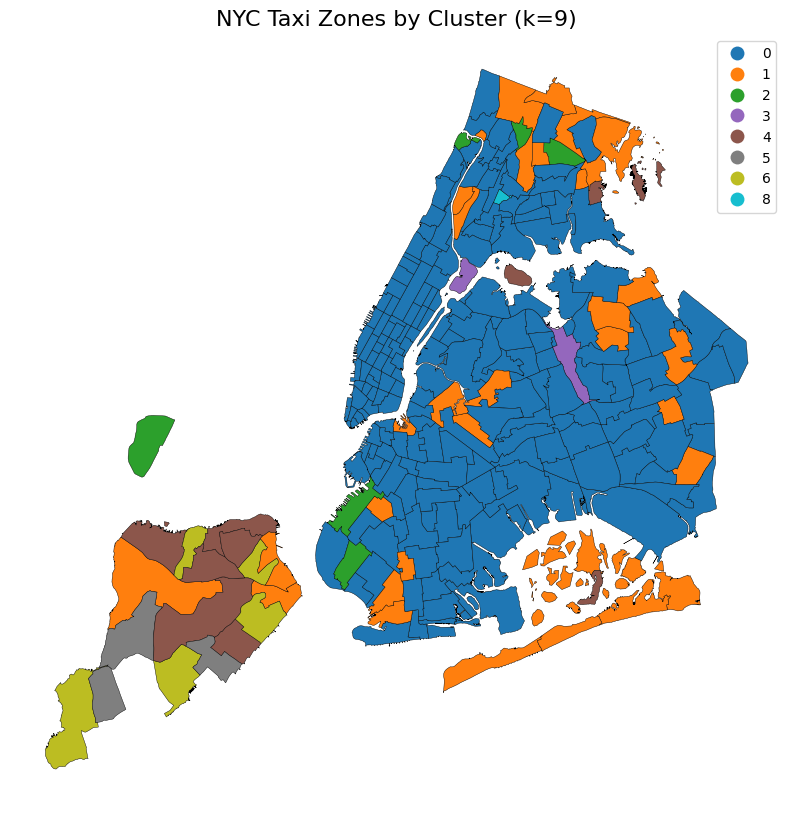

In [10]:
import geopandas as gpd

# Step 5: Load NYC Taxi Zone Geometry
# Replace 'NYC_Taxi_Zones.geojson' with the path to your GeoJSON or shapefile containing zone geometries.
gdf_zones = gpd.read_file("NYC Taxi Zones.geojson")

# Step 2: Prepare zone_ids
zone_ids = zone_time_series.columns  # This is a Pandas Index
zone_ids = zone_ids.to_numpy()       # Convert to NumPy array
zone_ids = zone_ids.astype(int)      # Ensure integers

# Ensure location_id in gdf_zones is of the same type
gdf_zones["location_id"] = gdf_zones["location_id"].astype(int)

# Step 3: Filter geometry zones to only include zones with actual trip data
gdf_zones_filtered = gdf_zones[gdf_zones["location_id"].isin(zone_ids)]


# Step 3: Merge Cluster Labels with Filtered GeoDataFrame
# Ensure that the labels DataFrame is aligned with the filtered GeoDataFrame
df_clusters = pd.DataFrame({
    "zone_id": zone_ids,  # Use actual PULocationIDs
    "cluster": labels     # Use the cluster labels from clustering
})

# Merge the GeoDataFrame with cluster labels
gdf_zones_filtered = gdf_zones_filtered.merge(
    df_clusters, 
    left_on="location_id",  # GeoDataFrame's zone identifier
    right_on="zone_id",     # Cluster labels zone identifier
    how="left"              # Left join ensures zones not in `zone_ids` are excluded
)

# Step 4: Plot the Clusters on a Map
fig, ax = plt.subplots(figsize=(10, 10))
gdf_zones_filtered.plot(
    column="cluster",        # Color polygons by cluster label
    categorical=True,        # Treat cluster labels as categories
    cmap="tab10",            # Use a discrete colormap (e.g., 'tab10' or 'tab20')
    legend=True,             # Display a legend
    linewidth=0.3,           # Set boundary line width
    edgecolor="black",       # Color of boundary lines
    ax=ax
)

# Add a title and remove axes for a clean map
ax.set_title("NYC Taxi Zones by Cluster (k=9)", fontsize=16)
ax.axis("off")  # Hide axis lines

# Show the plot
plt.show()


In [7]:
# Save df_clusters as a CSV file
df_clusters.to_csv("df_clusters.csv", index=False)

### K-Means

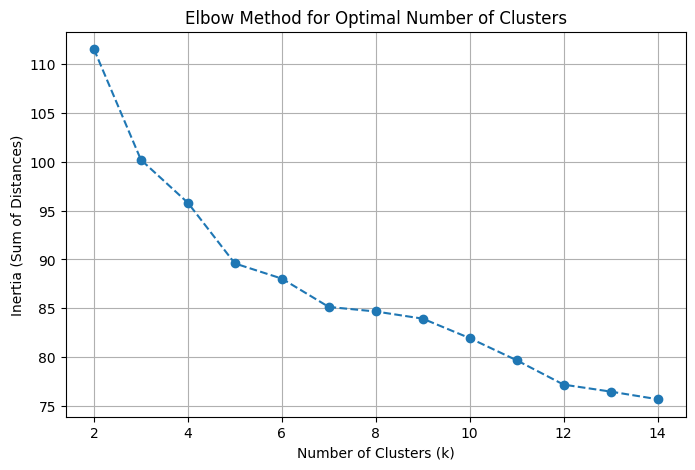

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tslearn.clustering import TimeSeriesKMeans
from tslearn.preprocessing import TimeSeriesScalerMeanVariance
import geopandas as gpd


# 1. Data Loading and Preprocessing
# Path to the Parquet file
file_path = 'filtered_df_2.parquet'

# Load the Parquet file into a DataFrame
df_trips = pd.read_parquet(file_path)

# Ensure that 'tpep_pickup_datetime' is in datetime format
df_trips['tpep_pickup_datetime'] = pd.to_datetime(df_trips['tpep_pickup_datetime'])

# Extract relevant time features
df_trips['pickup_date'] = df_trips['tpep_pickup_datetime'].dt.date

# Aggregate total pickups per zone per day
zone_daily_demand = df_trips.groupby(['PULocationID', 'pickup_date']).size().reset_index(name='pickup_count')

# Pivot to create a time series for each zone
zone_time_series = zone_daily_demand.pivot(index='pickup_date', columns='PULocationID', values='pickup_count').fillna(0)

# Transpose for clustering (zones as rows, time series as columns)
zone_time_series_matrix = zone_time_series.T

# 2. Scaling the Time Series Data
scaler = TimeSeriesScalerMeanVariance()
zone_ts_scaled = scaler.fit_transform(zone_time_series_matrix.values)

# 3. Elbow Method to Determine Optimal Number of Clusters
# Define the range of k values to try
k_values = range(2, 15)
inertia = []

for k in k_values:
    model = TimeSeriesKMeans(n_clusters=k, metric="dtw", max_iter=10, random_state=42, n_jobs=-1)
    model.fit(zone_ts_scaled)
    inertia.append(model.inertia_)

# Plot the Elbow Curve
plt.figure(figsize=(8, 5))
plt.plot(k_values, inertia, marker='o', linestyle='--')
plt.title("Elbow Method for Optimal Number of Clusters")
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Inertia (Sum of Distances)")
plt.grid()
plt.show()


   zone_id  cluster
0        1        3
1        2        1
2        3        4
3        4        2
4        6        1


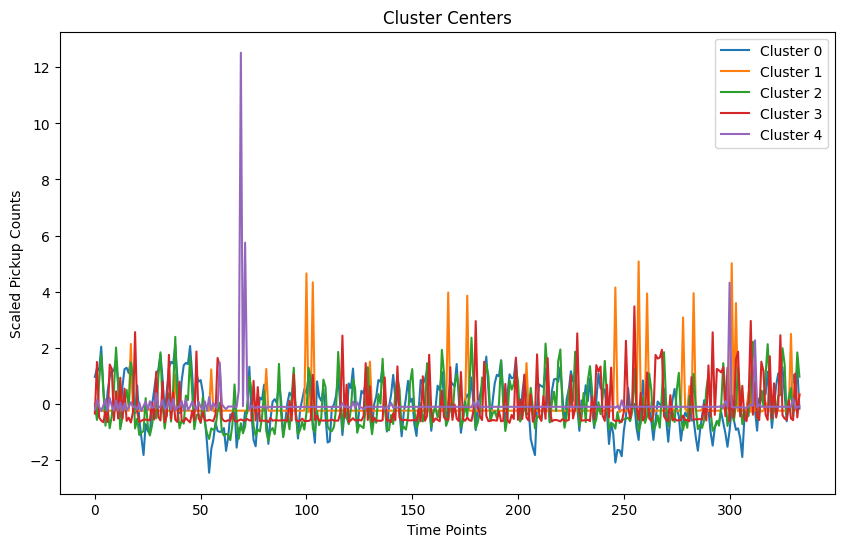

   VendorID tpep_pickup_datetime tpep_dropoff_datetime  trip_duration  \
0         1  2023-11-01 00:03:03   2023-11-01 01:04:08      61.083333   
1         2  2023-11-01 00:03:50   2023-11-01 00:04:59       1.150000   
2         2  2023-11-01 00:06:30   2023-11-01 00:14:25       7.916667   
3         2  2023-11-01 00:17:18   2023-11-01 00:23:39       6.350000   
4         2  2023-11-01 00:14:49   2023-11-01 00:39:44      24.916667   

   pickup_hour pickup_day_of_week  passenger_count  trip_distance  RatecodeID  \
0            0          Wednesday              2.0          13.60         1.0   
1            0          Wednesday              1.0           0.39         1.0   
2            0          Wednesday              1.0           1.20         1.0   
3            0          Wednesday              3.0           0.60         1.0   
4            0          Wednesday              1.0           5.44         1.0   

   PULocationID  DOLocationID  payment_type  fare_amount  tip_amount  \
0 

In [6]:

# Based on the Elbow plot, choose an optimal k. For example, let's choose k=9
optimal_k = 5

# 4. K-Means Clustering with Optimal k
kmeans = TimeSeriesKMeans(n_clusters=optimal_k, metric="dtw", max_iter=100, random_state=42, n_jobs=-1)
cluster_labels = kmeans.fit_predict(zone_ts_scaled)

# 5. Assigning Cluster Labels to Zones
zone_ids = zone_time_series.columns  # These are the actual PULocationIDs
df_clusters = pd.DataFrame({
    'zone_id': zone_ids,
    'cluster': cluster_labels
})

print(df_clusters.head())

# 6. (Optional) Visualizing Cluster Centers
plt.figure(figsize=(10, 6))
for cluster in range(optimal_k):
    plt.plot(kmeans.cluster_centers_[cluster].ravel(), label=f'Cluster {cluster}')
plt.title('Cluster Centers')
plt.xlabel('Time Points')
plt.ylabel('Scaled Pickup Counts')
plt.legend()
plt.show()

# 7. (Optional) Assigning Clusters Back to Original Data
# If you want to merge cluster labels back to the original dataframe
df_trips = df_trips.merge(df_clusters, left_on='PULocationID', right_on='zone_id', how='left')

# Now, df_trips contains a 'cluster' column indicating the cluster each zone belongs to
print(df_trips.head())


In [7]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt

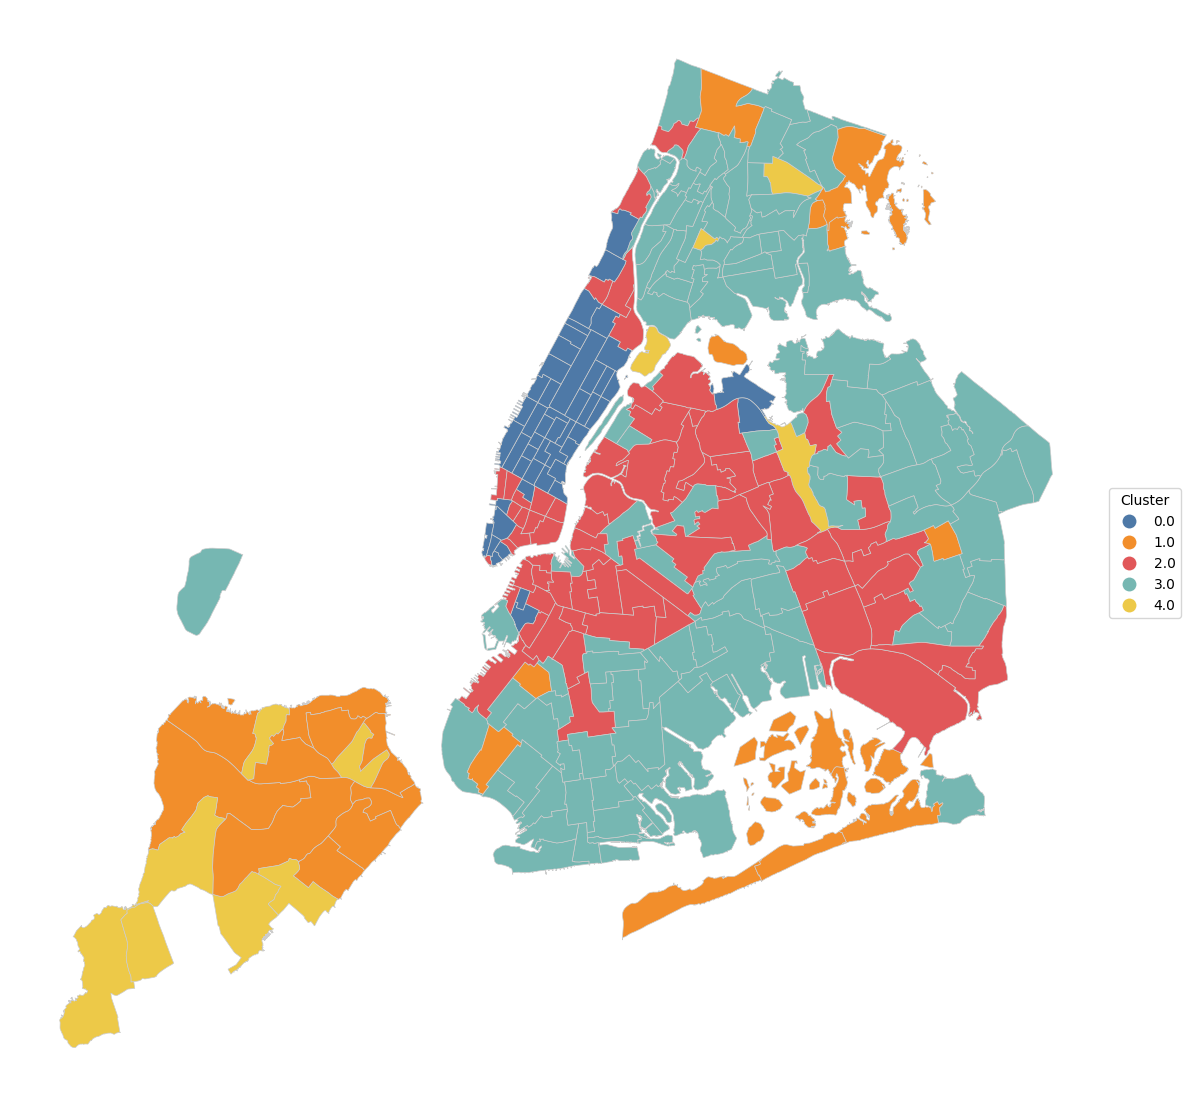

In [25]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

# Load NYC Taxi Zone Geometry
gdf_zones = gpd.read_file("NYC Taxi Zones.geojson")
gdf_zones["location_id"] = gdf_zones["location_id"].astype(int)

# Load cluster data
df_clusters = pd.read_csv('df_clusters.csv')
df_clusters['cluster'] = df_clusters['cluster'].astype(int)  # Convert to integer

# Merge Cluster Labels with GeoDataFrame
gdf_zones_filtered = gdf_zones.merge(
    df_clusters,
    left_on="location_id",
    right_on="zone_id",
    how="left"
)

# Create a custom colormap with more visually appealing colors
colors = ['#4e79a7', '#f28e2b', '#59a14f', '#e15759', '#76b7b2', 
          '#edc948', '#b07aa1', '#ff9da7', '#9c755f', '#bab0ac']
n_clusters = len(gdf_zones_filtered['cluster'].unique())
custom_cmap = ListedColormap(colors[:n_clusters])

# Create the plot
fig, ax = plt.subplots(figsize=(12, 12))

# Plot the map
gdf_zones_filtered.plot(
    column="cluster",
    categorical=True,
    cmap=custom_cmap,
    legend=True,
    linewidth=0.5,
    edgecolor="0.8",
    ax=ax,
    legend_kwds={
        'title': 'Cluster',
        'loc': 'center left',
        'bbox_to_anchor': (1, 0.5),
        'fmt': '{:.0f}',  # Format legend labels as integers
        'frameon': True
    }
)

# Remove axes
ax.set_axis_off()

# Add title
# plt.title('NYC Taxi Zones Clustering Analysis', pad=20, fontsize=14)

# Adjust layout to prevent legend cutoff
plt.tight_layout()

plt.show()

In [23]:
# Save df_clusters as a CSV file
df_clusters.to_csv("df_clusters.csv", index=False)

In [5]:
import geopandas as gpd
import pandas as pd

# Load the GeoJSON file into a GeoDataFrame
gdf_zones = gpd.read_file("NYC Taxi Zones.geojson")

# Inspect the first few rows to understand the structure
print(gdf_zones.head())

# Display all column names to identify relevant fields
print(gdf_zones.columns)

gdf_zones['borough'].unique()


          shape_area objectid       shape_leng location_id  \
0    0.0007823067885        1   0.116357453189           1   
1   0.00486634037837        2    0.43346966679           2   
2  0.000314414156821        3  0.0843411059012           3   
3  0.000111871946192        4  0.0435665270921           4   
4  0.000497957489363        5  0.0921464898574           5   

                      zone        borough  \
0           Newark Airport            EWR   
1              Jamaica Bay         Queens   
2  Allerton/Pelham Gardens          Bronx   
3            Alphabet City      Manhattan   
4            Arden Heights  Staten Island   

                                            geometry  
0  MULTIPOLYGON (((-74.18445 40.69500, -74.18449 ...  
1  MULTIPOLYGON (((-73.82338 40.63899, -73.82277 ...  
2  MULTIPOLYGON (((-73.84793 40.87134, -73.84725 ...  
3  MULTIPOLYGON (((-73.97177 40.72582, -73.97179 ...  
4  MULTIPOLYGON (((-74.17422 40.56257, -74.17349 ...  
Index(['shape_area', 'obje

array(['EWR', 'Queens', 'Bronx', 'Manhattan', 'Staten Island', 'Brooklyn'],
      dtype=object)

In [6]:
# Define the mapping from borough to cluster number, including EWR
borough_to_cluster = {
    'Manhattan': 1,
    'Brooklyn': 2,
    'Queens': 3,
    'Bronx': 4,
    'Staten Island': 5,
    'EWR': 0  # Assigning EWR to Cluster 0
}

In [12]:
# Map 'Borough' to 'cluster'
if 'borough' not in gdf_zones.columns:
    raise ValueError("The GeoDataFrame does not contain a 'Borough' column.")

gdf_zones['cluster'] = gdf_zones['borough'].map(borough_to_cluster)

# Assign Cluster 0 to zones without a borough
gdf_zones['cluster'] = gdf_zones['cluster'].fillna(0).astype(int)

# Verify the mapping
print(gdf_zones[['location_id', 'borough', 'cluster']].head())

# 3. Create and Save the 'zone_clusters.csv' File
df_clusters = gdf_zones[['location_id', 'cluster']].copy()
df_clusters.rename(columns={'location_id': 'zone_id'}, inplace=True)
df_clusters.to_csv('zone_clusters.csv', index=False)

  location_id        borough  cluster
0           1            EWR        0
1           2         Queens        3
2           3          Bronx        4
3           4      Manhattan        1
4           5  Staten Island        5
